In [1]:
# Add the source directory to the path
import sys
sys.path.append('/home/sleyse4/repos/LoRE_SD/LoRE-SD/src')
sys.path.append('/home/sleyse4/repos/LoRE_SD/LoRE-SD')


In [2]:
import os
import subprocess
import shutil
import PIL

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.ndimage
from scipy.ndimage import gaussian_filter

from utils import gradient_utils, plot_utils, io_utils, math_utils
from optimisation import optimise

import contrasts

from mrtrix_io.io import load_mrtrix, save_mrtrix
from mrtrix_io.io.image import Image

import utils.SphericalHarmonics as sh

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.transforms import Bbox

In [3]:
# Add the MRtrix3 binary directory to the PATH
mrtrix_bin_dir = '/SOFTWARE/mrtrix3/bin'  # Replace with the actual path to MRtrix3 binaries
os.environ['PATH'] += os.pathsep + mrtrix_bin_dir

In [48]:
sub = 'PT002'
DATASERVER = f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-{sub}'
img_dir = os.path.join(DATASERVER, 'figs')

# List all images in the directory
images = [f for f in os.listdir(img_dir) if f.endswith('png')]
images = sorted(images)

In [49]:
images = [f for f in os.listdir(img_dir) if f.endswith('png') and 'lesion' not in f.lower() and 'overlay' not in f.lower()]

for img_path in images:
    img = plt.imread(os.path.join(img_dir, img_path))
    # # Load the lesion using PIL
    t = PIL.Image.open(os.path.join(img_dir, img_path))
    dpi = np.average(t.info['dpi'])

    fig_width, fig_height = img.shape[1] / dpi, img.shape[0] / dpi
    # fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    dpi = np.average(t.info['dpi'])
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

    ax.imshow(img)
    

    if 'ODF' in img_path:
        lesion_img = plt.imread(os.path.join(img_dir, 'LESION_ODF0000.png'))
        smooth_lesion = np.average(gaussian_filter(lesion_img, sigma=30), axis=-1)
        ax.contour(smooth_lesion, levels=[.5], colors='r', linewidths=[10])

        
    elif 'TRACT' in img_path:
        lesion_img = plt.imread(os.path.join(img_dir, 'LESION_TRACT0000.png'))
        smooth_lesion = np.average(gaussian_filter(lesion_img, sigma=7), axis=-1)
        ax.contour(smooth_lesion, levels=[.5], colors='r', linewidths=[4])


    ax.axis('off')

    fig.savefig(os.path.join(img_dir, img_path.replace('0000','_overlay')), transparent=True, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

[['MTCSD_ODF_overlay.png' 'FA_ODF_overlay.png' 'IAX_ODF_overlay.png']
 ['MTCSD_TRACT_overlay.png' 'FA_TRACT_overlay.png'
  'IAX_TRACT_overlay.png']]


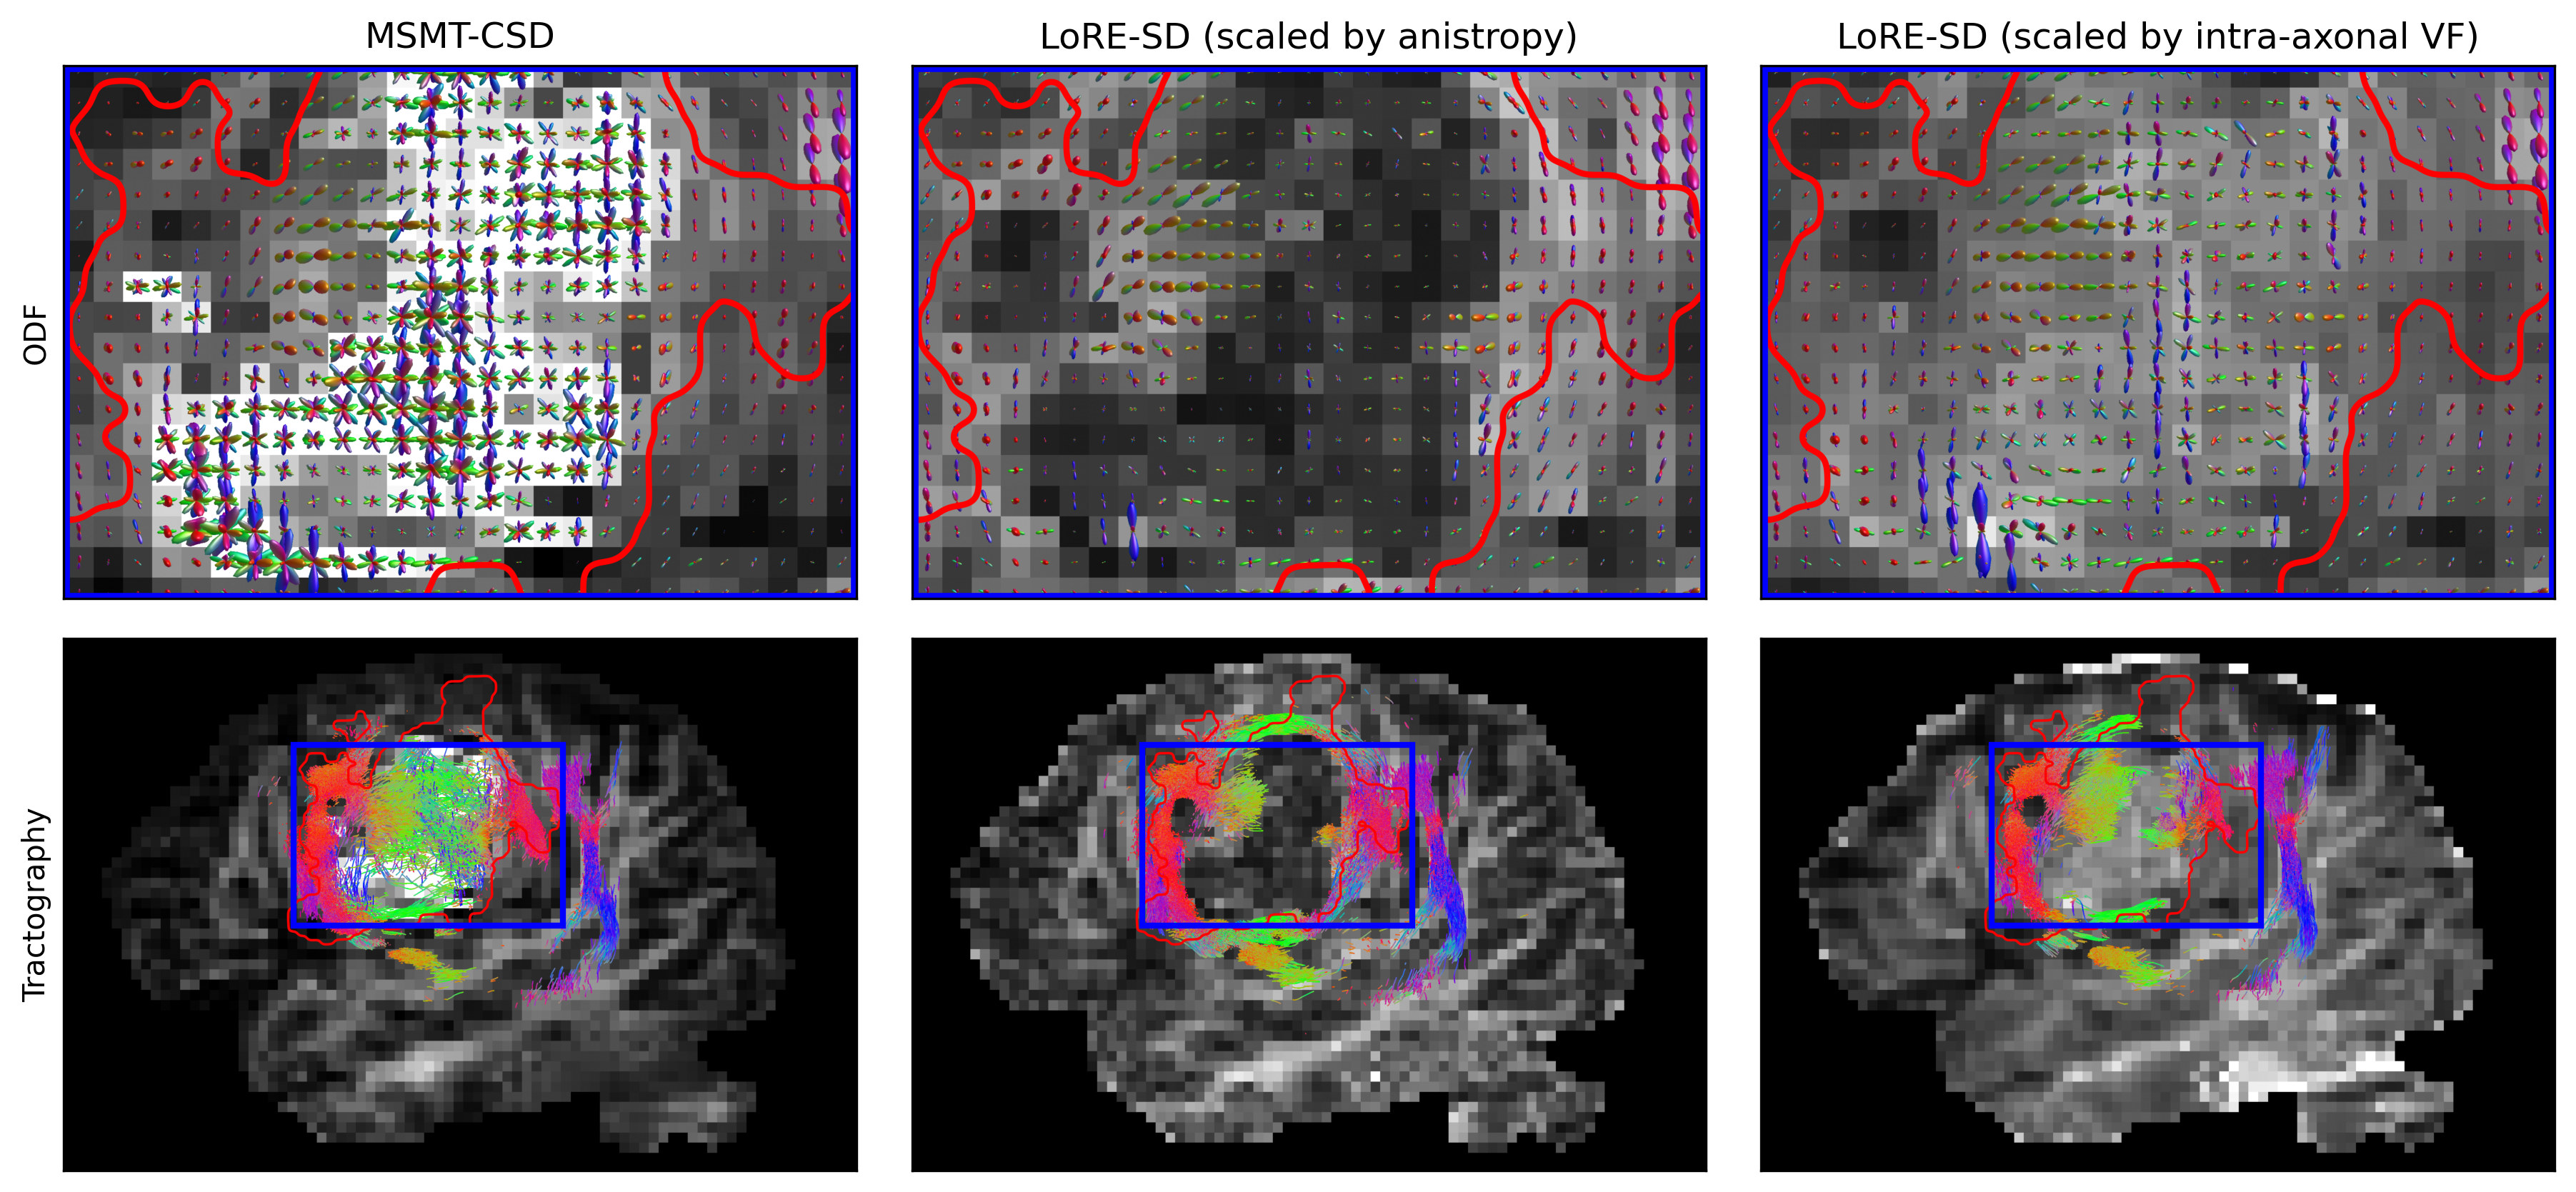

In [55]:
# Combine all pictures together
images = [f for f in os.listdir(img_dir) if f.endswith('overlay.png')]
images = sorted(images)
# This orders images as FA_ODF, FA_TRACT, IAX_ODF, IAX_TRACT, MTCSD_ODF, MTCSD_TRACT

img_shape = plt.imread(os.path.join(img_dir, images[0])).shape
images = np.array(images).reshape(3,2).T
images[:, [0, 1]] = images[:, [1, 0]]
images[:, [0, 2]] = images[:, [2, 0]]
titles = ['MSMT-CSD', 'LoRE-SD (scaled by anistropy)', 'LoRE-SD (scaled by intra-axonal VF)']
print(images)
rows, cols = 2, 3
fig = plt.figure(figsize=(cols * 5, rows * 5 * img_shape[0] / img_shape[1]), dpi=300)
gs = fig.add_gridspec(rows, cols, wspace=0.07, hspace=0.07)
for row, img_row in enumerate(images):
    for col, (title, img) in enumerate(zip(titles, img_row)):
        ax = fig.add_subplot(gs[row, col])
        img = plt.imread(os.path.join(img_dir, img))
        ax.imshow(img)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        if row == 0:
            ax.set_title(title)
            if col == 0:
                ax.set_ylabel('ODF')
        else:
            if col == 0:
                ax.set_ylabel('Tractography')
        
        if row == 1:
            # Add a rectangle to the image
            rect = plt.Rectangle((.29*img.shape[1], .2*img.shape[0]), .34*img_shape[1], .34*img_shape[0], linewidth=2, edgecolor='blue', fill=False, facecolor='none')
            ax.add_patch(rect)
        else:
            rect = plt.Rectangle((0,0), img_shape[1], img_shape[0], linewidth=4, edgecolor='blue', fill=False, facecolor='none')
            ax.add_patch(rect)
plt.savefig(os.path.join(img_dir, 'combined.png'), transparent=True, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
healthy_sub = '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/philips'
